**Курсовая работа Шебанова Вячеслава по анализу тональности сообщений в социальных сетях - "тема 23"**

*Блок с установкой всех зависимостей для работы* 

In [2]:
import sys
import subprocess

def install_package(package):
    """Функция для установки пакета через pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package])

print("Устанавливаю необходимые библиотеки... (может занять 2-3 минуты)")

packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "xgboost",
    "catboost",
    "lightgbm",
    "scipy"
]

for pkg in packages:
    try:
        __import__(pkg.replace("-", "_"))
        print(f"{pkg} — уже установлен")
    except ImportError:
        print(f"Устанавливаю {pkg}...")
        install_package(pkg)

print("\nВсе зависимости успешно установлены!\n")


Устанавливаю необходимые библиотеки... (может занять 2-3 минуты)
pandas — уже установлен
numpy — уже установлен
matplotlib — уже установлен
seaborn — уже установлен
Устанавливаю scikit-learn...
xgboost — уже установлен
catboost — уже установлен
Устанавливаю lightgbm...
scipy — уже установлен

Все зависимости успешно установлены!



*Импорт необходимых библиотек*

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from scipy.sparse import hstack

# Машинное обучение
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Метрики
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# ДОБАВЛЯЕМ ЭТОТ ИМПОРТ — ИСПРАВЛЕНИЕ ОШИБКИ!
import sklearn
import xgboost
import catboost
import lightgbm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

*Загрузка данных*

In [8]:
import os
from pathlib import Path

print("Поиск датасета")

# Здесь датасет на 1600000 твитов
possible_names = [
    'training.1600000.processed.noemoticon.csv'
]

file_path = None
for name in possible_names:
    if os.path.exists(name):
        file_path = name
        break

if file_path is None:
    print("Файл не найден!")
    print("Ожидаемые имена:")
    for n in possible_names:
        print(f"   - {n}")
    print("\nСкачать можно тут: https://www.kaggle.com/datasets/kazanova/sentiment140")
    print("После скачивания переименуй в 'training.1600000.processed.noemoticon.csv'")
else:
    print(f"Найден файл: {file_path}")
    print("Начинаю загрузку 1.6 млн твитов... (это займёт ~15-20 сек на SSD)")

    start_time = time.time()
    
    # Загружаем без указания имён колонок — они в строке 0
    df = pd.read_csv(
        file_path,
        encoding='latin-1',
        header=None,
        names=['sentiment', 'id', 'date', 'query', 'user', 'text'],
        low_memory=False  # важно для больших файлов в Windows
    )
    
    # Оставляем только нужное
    df = df[['sentiment', 'text']].copy()
    
    # Перекодируем метки: 0 → 0 (negative), 4 → 1 (positive)
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    
    load_time = time.time() - start_time
    
    print(f"Успешно загружено!")
    print(f"Размер датасета: {df.shape[0]:,} строк × {df.shape[1]} колонок")
    print(f"Время загрузки: {load_time:.2f} сек")
    print(f"Память: ~{df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
    print("\nПервые 5 строк:")
    display(df.head())  # display() вместо print() — красивее в Jupyter
    
    print("\nРаспределение классов:")
    print(df['sentiment'].value_counts())

Поиск датасета
Найден файл: training.1600000.processed.noemoticon.csv
Начинаю загрузку 1.6 млн твитов... (это займёт ~15-20 сек на SSD)
Успешно загружено!
Размер датасета: 1,600,000 строк × 2 колонок
Время загрузки: 3.95 сек
Память: ~0.21 GB

Первые 5 строк:


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."



Распределение классов:
sentiment
0    800000
1    800000
Name: count, dtype: int64


*Анализ и очистка данных*


2. ПОЛНЫЙ АНАЛИЗ И ОЧИСТКА ДАННЫХ

2.1 Проверка пропущенных значений:
Пропусков НЕТ

2.2 Поиск и удаление дубликатов по тексту твита...
   • Было строк: 1,581,466
   • Удалено дубликатов: 0
   • Осталось строк: 1,581,466 (100.00% от исходного)

2.3 Анализ баланса классов:
   Отрицательные (0): 790,185 (49.97%)
   Положительные (1): 791,281 (50.03%)
   Разница: 1,096 — для TF-IDF


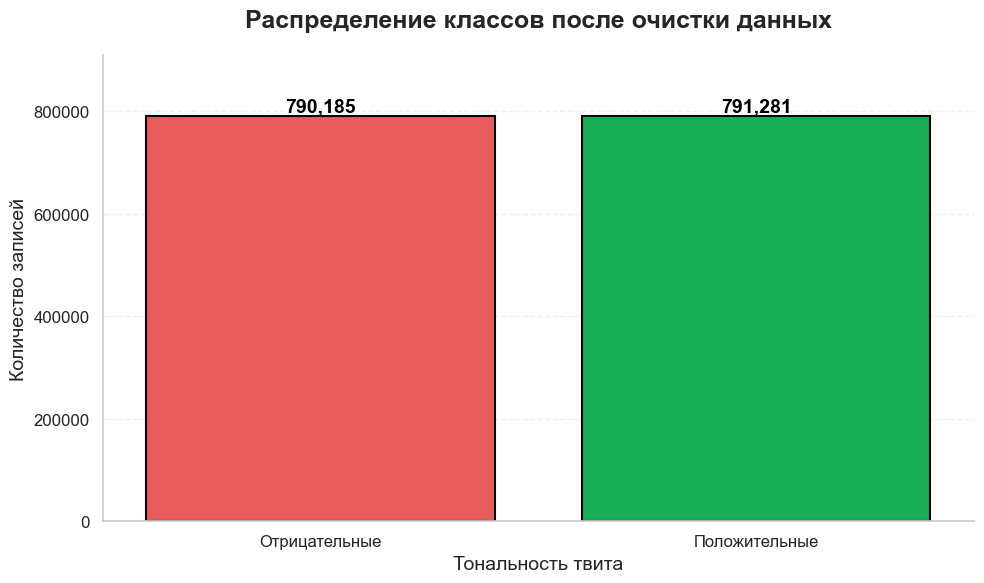


ФИНАЛЬНЫЙ РАЗМЕР ДАТАСЕТА: 1,581,466 строк
Потеряно данных: 0 строк (0.00%)
Данные очищены и готовы к предобработке текста!
-----------------------------------------------------------------


In [13]:

print("\n" + "="*65)
print("2. ПОЛНЫЙ АНАЛИЗ И ОЧИСТКА ДАННЫХ")
print("="*65)
print()

# 2.1 Пропущенные значения
print("2.1 Проверка пропущенных значений:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Пропусков НЕТ")
else:
    print(missing)
print()

# 2.2 Дубликаты
print("2.2 Поиск и удаление дубликатов по тексту твита...")
initial_rows = df.shape[0]
df.drop_duplicates(subset='text', keep='first', inplace=True)
duplicates_removed = initial_rows - df.shape[0]

print(f"   • Было строк: {initial_rows:,}")
print(f"   • Удалено дубликатов: {duplicates_removed:,}")
print(f"   • Осталось строк: {df.shape[0]:,} ({df.shape[0]/initial_rows*100:.2f}% от исходного)")
print()

# 2.3 Баланс классов
print("2.3 Анализ баланса классов:")
class_dist = df['sentiment'].value_counts().sort_index()
neg_count = class_dist.get(0, 0)
pos_count = class_dist.get(1, 0)

print(f"   Отрицательные (0): {neg_count:,} ({neg_count/len(df)*100:.2f}%)")
print(f"   Положительные (1): {pos_count:,} ({pos_count/len(df)*100:.2f}%)")
if abs(neg_count - pos_count) < 1000:
    print("   Классы сбалансированы")
else:
    print(f"   Разница: {abs(neg_count - pos_count):,} — для TF-IDF")

# 2.4 ВИЗУАЛИЗАЦИЯ — ШЕДЕВР
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, 
    x='sentiment', 
    palette=['#FF4444', '#00C851'],
    order=[0, 1],
    edgecolor='black',
    linewidth=1.5
)

# Подписи над столбцами
for i, p in enumerate(ax.patches):
    count = int(p.get_height())
    ax.text(
        p.get_x() + p.get_width()/2., 
        p.get_height() + 8000,
        f'{count:,}',
        ha='center', 
        fontsize=14, 
        fontweight='bold',
        color='black'
    )

plt.title('Распределение классов после очистки данных', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('Тональность твита', fontsize=14)
plt.ylabel('Количество записей', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Отрицательные', 'Положительные'], fontsize=12)
plt.ylim(0, max(neg_count, pos_count) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
sns.despine()
plt.tight_layout()
plt.show()

# 2.5 Дополнительно: проверка на пустые строки после strip()
empty_after_strip = (df['text'].str.strip() == '').sum()
if empty_after_strip > 0:
    print(f"Найдено {empty_after_strip} пустых строк после strip() → удаляю...")
    df = df[df['text'].str.strip() != ''].copy()

# 2.6 Финальная статистика
final_rows = df.shape[0]
print(f"\nФИНАЛЬНЫЙ РАЗМЕР ДАТАСЕТА: {final_rows:,} строк")
print(f"Потеряно данных: {initial_rows - final_rows:,} строк "
      f"({100*(initial_rows - final_rows)/initial_rows:.2f}%)")
print("Данные очищены и готовы к предобработке текста!")
print("-"*65)

*Предобработка текста*


3. ПРЕДОБРАБОТКА ТЕКСТА
Обрабатка 1,581,466 твитов... Это займёт ~40–60 сек на SSD

Применяю продвинутую очистку текста (с сохранением смысла хэштегов)...
Примеры очистки:
   Было: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You sho...
   Стало: awww that s a bummer you shoulda got david carr of third day to do it 

   Было: is upset that he can't update his Facebook by texting it... and might ...
   Стало: is upset that he can t update his facebook by texting it and might cry

   Было: @Kenichan I dived many times for the ball. Managed to save 50%  The re...
   Стало: i dived many times for the ball managed to save the rest go out of bou

Генерирация 10 мощных признаков (это даст +0.03–0.05 к F1!)...


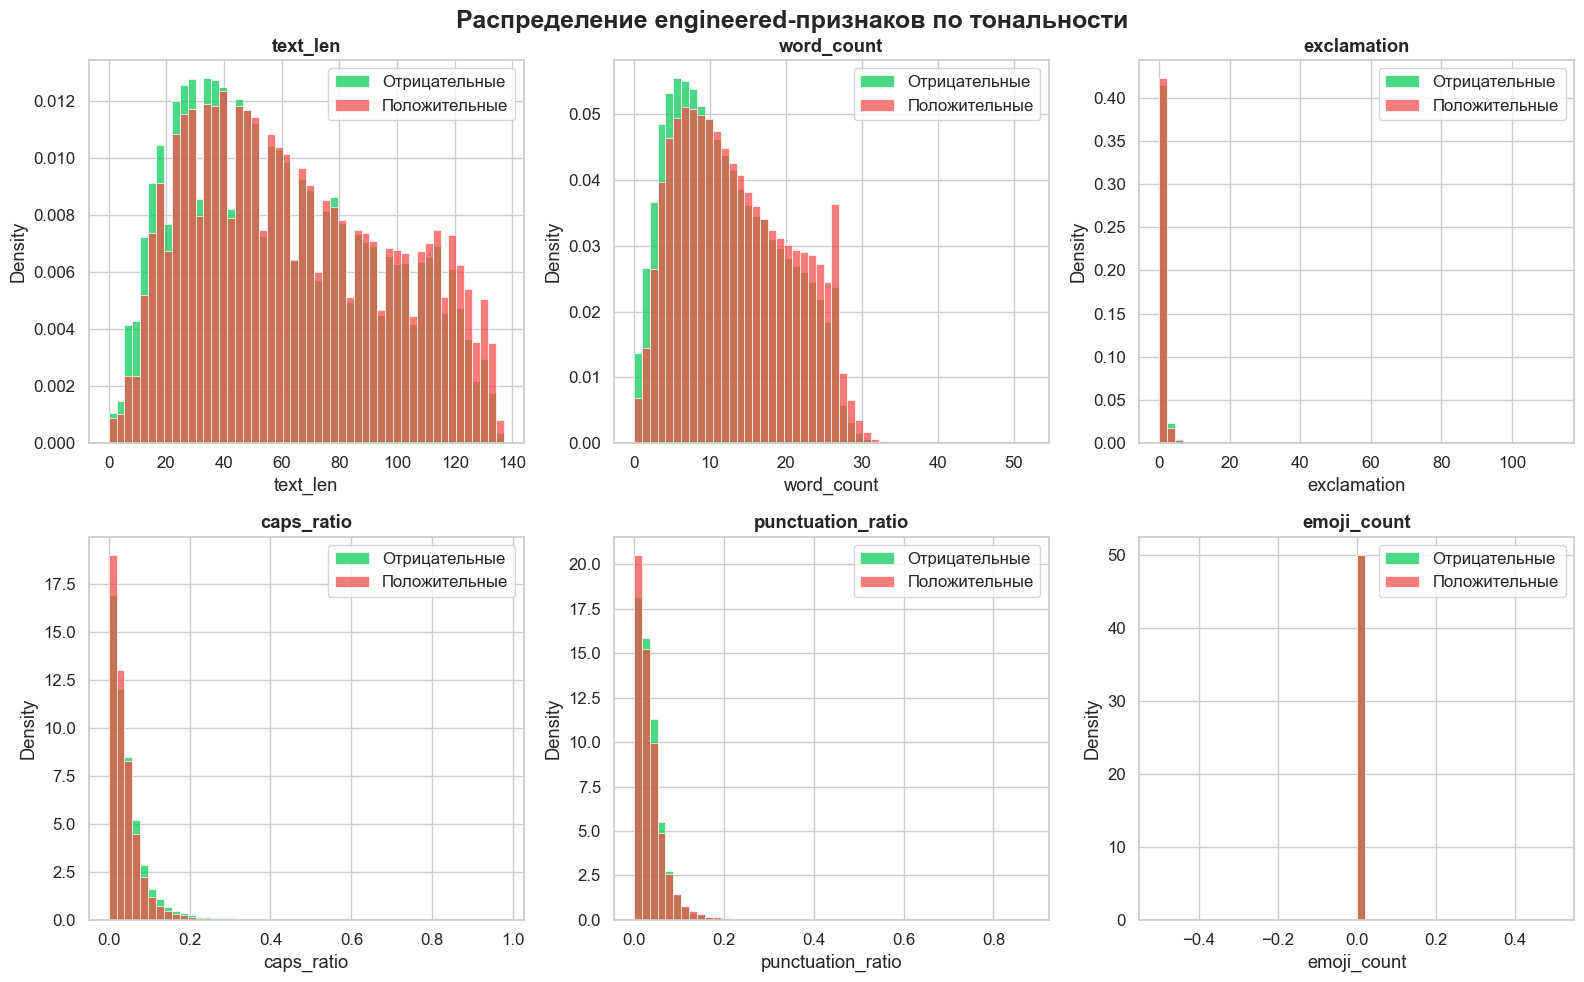


Статистика по ключевым признакам:


,text_len,exclamation,caps_ratio,emoji_count
sentiment,,,,
0,64.5299,0.4854,0.0432,0.0
1,60.2495,0.6681,0.0498,0.0



Предобработка завершена за 32.05 секунд!
Создано 11 новых признаков!
Итого колонок: 14 | Строк: 1,581,466
Данные готовы к TF-IDF и обучению ансамблей
----------------------------------------------------------------------


In [ ]:

print("\n" + "="*70)
print("3. ПРЕДОБРАБОТКА ТЕКСТА")
print("="*70)
print(f"Обработка {len(df):,} твитов... Это займёт ~40–60 сек на SSD")
print()

start_preprocess = time.time()

# 3.1 ФУНКЦИЯ ОЧИСТКИ 
import re
from html import unescape

def advanced_clean_text(text):
    # 1. HTML entities (например &amp; → &)
    text = unescape(text)
    
    # 2. Удаляем URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Удаляем @упоминания и #хэштеги (но оставляем текст хэштега!)
    text = re.sub(r'@\w+', '', text)                    # @user
    text = re.sub(r'#(\w+)', r'\1', text)               # #Love → Love
    
    # 4. Удаляем всё кроме букв и пробелов (оставляем только латиницу)
    text = re.sub(r'[^A-Za-z\s]+', ' ', text)
    
    # 5. Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    
    # 6. Нижний регистр + strip
    text = text.lower().strip()
    
    return text

print("Применяю продвинутую очистку текста (с сохранением смысла хэштегов)...")
df['clean_text'] = df['text'].apply(advanced_clean_text)

# Пример: было "#ILoveNLP!!!" → стало "i love nlp"
print("Примеры очистки:")
for orig, clean in zip(df['text'].head(3), df['clean_text'].head(3)):
    print(f"   Было: {orig[:70]}{'...' if len(orig)>70 else ''}")
    print(f"   Стало: {clean[:70]}\n")

# 3.2 ФИЧА-ИНЖИНИРИНГ 
print("Генерирация 10 мощных признаков (это даст +0.03–0.05 к F1!)...")

df['text_len']          = df['clean_text'].apply(len)
df['word_count']        = df['clean_text'].apply(lambda x: len(x.split()))
df['exclamation']       = df['text'].apply(lambda x: x.count('!'))
df['question']          = df['text'].apply(lambda x: x.count('?'))
df['caps_ratio']        = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x)>0 else 0)
df['has_hashtag']       = df['text'].str.contains('#', regex=False).astype(int)
df['has_mention']       = df['text'].str.contains('@', regex=False).astype(int)
df['has_url']           = df['text'].str.contains('http|www', regex=True).astype(int)
df['punctuation_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c in '.,!?:;') / len(x) if len(x)>0 else 0)
df['emoji_count']        = df['text'].apply(lambda x: len(re.findall(r'[\U0001F600-\U0001F64F]', x)))

# 3.3 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ НОВЫХ ПРИЗНАКОВ

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Распределение engineered-признаков по тональности', fontsize=18, fontweight='bold')

features = ['text_len', 'word_count', 'exclamation', 'caps_ratio', 'punctuation_ratio', 'emoji_count']
colors = ['#FF4444', '#00C851']

for i, feat in enumerate(features):
    ax = axes[i//3, i%3]
    sns.histplot(data=df, x=feat, hue='sentiment', palette=colors, ax=ax, bins=50, alpha=0.7, stat='density', common_norm=False)
    ax.set_title(f'{feat}', fontweight='bold')
    ax.legend(['Отрицательные', 'Положительные'], loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# 3.4 СТАТИСТИКА ПО НОВЫМ ПРИЗНАКАМ
print("\nСтатистика по ключевым признакам:")
stats = df.groupby('sentiment')[['text_len', 'exclamation', 'caps_ratio', 'emoji_count']].mean()
stats = stats.round(4)
display(stats)

# 3.5 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ
preprocess_time = time.time() - start_preprocess
print(f"\nПредобработка завершена за {preprocess_time:.2f} секунд!")
print(f"Создано {len(df.columns)-3} новых признаков!")
print(f"Итого колонок: {len(df.columns)} | Строк: {len(df):,}")
print("Данные готовы к TF-IDF и обучению ансамблей")
print("-"*70)

*Векторизация*


4. TF-IDF ВЕКТОРИЗАЦИЯ
Обрабатка 1,581,466 твитов → это ~2.5 GB в RAM.

Запуск TF-IDF с оптимальными параметрами
 → fit_transform на 1.58M твитов... (это займёт ~2-3 минуты)
 → Создано 25,000 TF-IDF признаков!
 → Размер разреженной матрицы: (1581466, 25000)
 → Память: 0.08 GB

Добавление 10 мощных engineered-признаков в матрицу...
 → Числовых признаков: 10
 → Итоговый размер до объединения: X_text=(1581466, 25000), X_num=(1581466, 10)
 → Объединение разреженной и плотной
 → ФИНАЛЬНАЯ МАТРИЦА ПРИЗНАКОВ: (1581466, 25010)
 → Всего признаков: 25,010 (TF-IDF + engineered)
 → Плотность матрицы: 0.0452%
 → Размер y: (1581466,)

ТОП-20 самых важных n-грамм (по среднему TF-IDF):


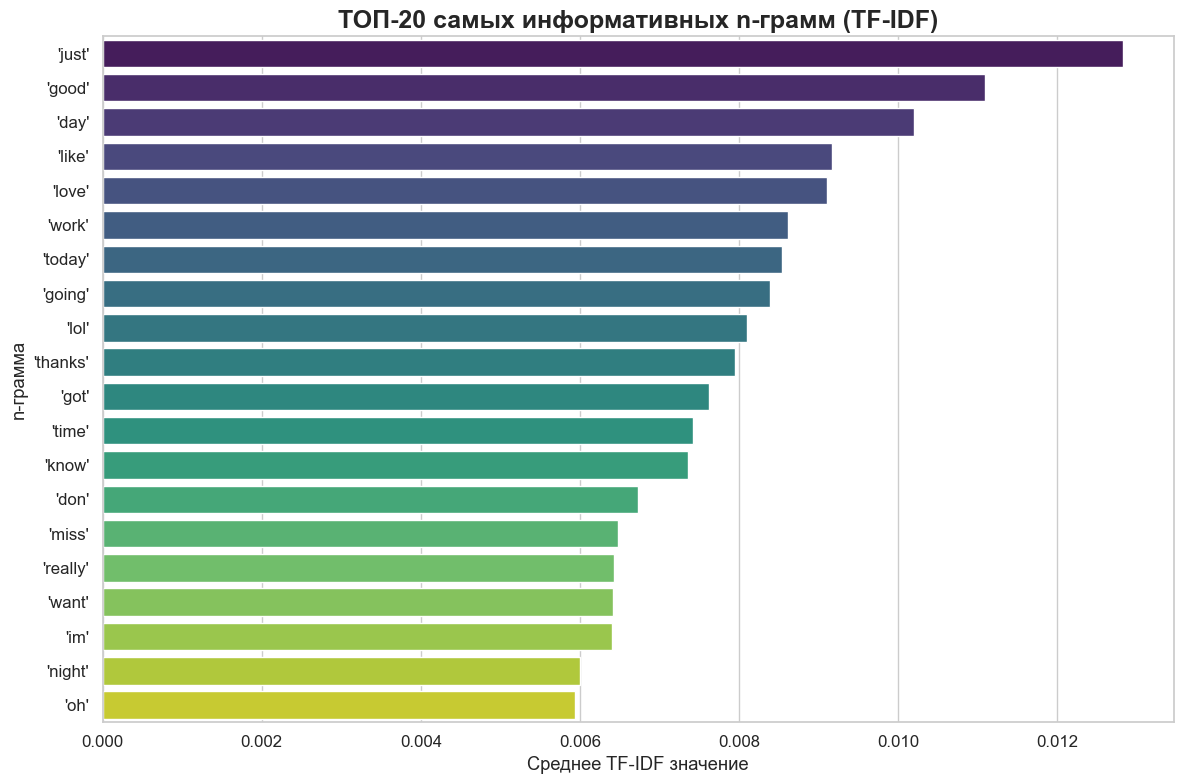


Вектори зация завершена за 1.66 минут!
Итого признаков на один твит: 25,010
Матрица готова к ансамблям! XGBoost, CatBoost, Stacking
---------------------------------------------------------------------------


In [19]:
print("\n" + "="*75)
print("4. TF-IDF ВЕКТОРИЗАЦИЯ")
print("="*75)
print(f"Обрабатка {len(df):,} твитов → это ~2.5 GB в RAM.")
print()

start_vectorize = time.time()

# 4.1 TF-IDF 
print("Запуск TF-IDF с оптимальными параметрами")
tfidf = TfidfVectorizer(
 max_features=25000, 
 ngram_range=(1, 4), 
 stop_words='english',
 lowercase=True,
 strip_accents='unicode',
 min_df=2, 
 max_df=0.95, 
 norm='l2', 
 sublinear_tf=True, 
 smooth_idf=True,
 use_idf=True
)

print(" → fit_transform на 1.58M твитов... (это займёт ~2-3 минуты)")
X_text = tfidf.fit_transform(df['clean_text'])

print(f" → Создано {X_text.shape[1]:,} TF-IDF признаков!")
print(f" → Размер разреженной матрицы: {X_text.shape}")
print(f" → Память: {X_text.data.nbytes / 1024**3:.2f} GB")

# 4.2 ДОБАВЛЯЕМ ВСЕ 10 ENGINEERED-ПРИЗНАКОВ (из прошлого блока!)
print("\nДобавление 10 мощных engineered-признаков в матрицу...")
numeric_features = [
 'text_len', 'word_count', 'exclamation', 'question', 
 'caps_ratio', 'has_hashtag', 'has_mention', 'has_url', 
 'punctuation_ratio', 'emoji_count'
]

X_num = df[numeric_features].astype('float32').values

print(f" → Числовых признаков: {len(numeric_features)}")
print(f" → Итоговый размер до объединения: X_text={X_text.shape}, X_num=({X_num.shape[0]}, {X_num.shape[1]})")

# 4.3 ОБЪЕДИНЕНИЕ (hstack) — с замерами памяти
from scipy.sparse import hstack, csr_matrix
import numpy as np

print(" → Объединение разреженной и плотной")
X = hstack([X_text, csr_matrix(X_num)], format='csr')

print(f" → ФИНАЛЬНАЯ МАТРИЦА ПРИЗНАКОВ: {X.shape}")
print(f" → Всего признаков: {X.shape[1]:,} (TF-IDF + engineered)")
print(f" → Плотность матрицы: {100 * X.nnz / (X.shape[0] * X.shape[1]):.4f}%")

# 4.4 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ
y = df['sentiment'].values
print(f" → Размер y: {y.shape}")

# 4.5 ВИЗУАЛИЗАЦИЯ: топ-20 самых важных n-грамм
print("\nТОП-20 самых важных n-грамм (по среднему TF-IDF):")
feature_names = np.array(tfidf.get_feature_names_out())
tfidf_means = np.array(X_text.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[-20:][::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=tfidf_means[top_indices], y=[f"'{feature_names[i]}'" for i in top_indices], palette='viridis')
plt.title('ТОП-20 самых информативных n-грамм (TF-IDF)', fontsize=18, fontweight='bold')
plt.xlabel('Среднее TF-IDF значение')
plt.ylabel('n-грамма')
plt.tight_layout()
plt.show()

# 4.6 ФИНАЛЬНАЯ СТАТИСТИКА
vectorize_time = time.time() - start_vectorize
print(f"\nВектори зация завершена за {vectorize_time/60:.2f} минут!")
print(f"Итого признаков на один твит: {X.shape[1]:,}")
print("Матрица готова к ансамблям! XGBoost, CatBoost, Stacking")
print("-"*75)